<a href="https://colab.research.google.com/github/rivaldobilly/CNN-MNIST/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST image files into a 4-D Tensor (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 620kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.52MB/s]


In [4]:
# Test Data
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [13]:
# Model Class
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        # First Pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)

        # Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)

        # Re-View to Flatten it out
        X = X.view(-1, 5*5*16)

        # Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [14]:
# Create an Instance of CNN model
torch.manual_seed(16)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # The smaller the learning rate, the time taken is longer to train

In [18]:
import time
start_time = time.time()

# Create Variables To Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loops of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1 # start batches at 1
        y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[1] # add up the loader of correct predictions. Indexed off the first
        batch_corr = (predicted == y_train).sum() # sum the correct. True = 1, False = 0
        trn_corr += batch_corr # keep track as we go in training

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results
        if b % 900 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad(): # No gradient so we don't update our weights and biases with test
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
            tst_corr += (predicted == y_test).sum() # True = 1, False = 0, sum away

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
elapsed_time = current_time - start_time
print(f'Training Took: {round(elapsed_time/60, 2)} minutes.')

Epoch: 0 Batch: 900 Loss: 0.0003542662307154387
Epoch: 0 Batch: 1800 Loss: 0.007566975895315409
Epoch: 0 Batch: 2700 Loss: 4.5247194066178054e-05
Epoch: 0 Batch: 3600 Loss: 8.154251554515213e-05
Epoch: 0 Batch: 4500 Loss: 2.8869751986349e-05
Epoch: 0 Batch: 5400 Loss: 0.00019021297339349985
Epoch: 1 Batch: 900 Loss: 3.290969107183628e-05
Epoch: 1 Batch: 1800 Loss: 0.00026153665385209024
Epoch: 1 Batch: 2700 Loss: 0.002869979478418827
Epoch: 1 Batch: 3600 Loss: 0.0006375863449648023
Epoch: 1 Batch: 4500 Loss: 0.0012501018354669213
Epoch: 1 Batch: 5400 Loss: 0.0035573490895330906
Epoch: 2 Batch: 900 Loss: 0.010815695859491825
Epoch: 2 Batch: 1800 Loss: 1.2516937886175583e-06
Epoch: 2 Batch: 2700 Loss: 0.00018408775213174522
Epoch: 2 Batch: 3600 Loss: 6.641201616730541e-05
Epoch: 2 Batch: 4500 Loss: 1.5174798136285972e-05
Epoch: 2 Batch: 5400 Loss: 0.0013379412703216076
Epoch: 3 Batch: 900 Loss: 0.00022899960458744317
Epoch: 3 Batch: 1800 Loss: 0.00013999987277202308
Epoch: 3 Batch: 2700 

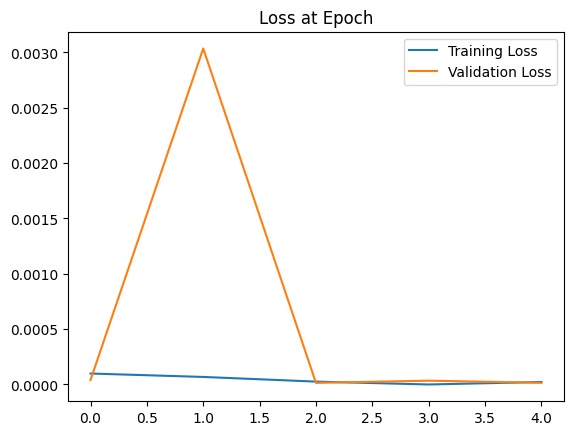

In [29]:
# Graph the Loss at Epoch
train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

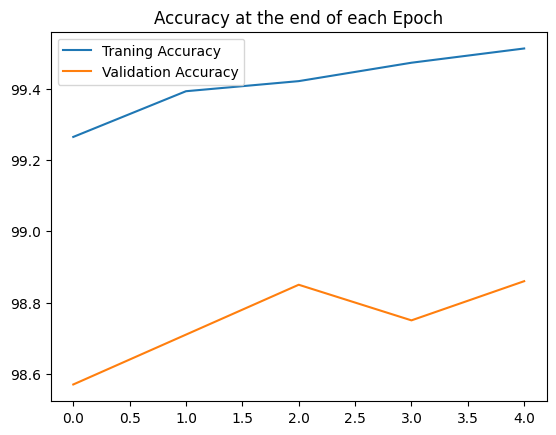

In [30]:
# Graph accuracy at the end of end of each epoch
plt.plot([t/600 for t in train_correct], label='Traning Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of each Epoch')
plt.legend()

In [31]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [33]:
# Did for correct
print(f'Test Data Accuracy: {correct.item()/len(test_data)*100}%')

Test Data Accuracy: 98.86%


In [34]:
# Grab an image
# Grab just the data (X)
X_data = test_data[2025][0]

In [37]:
# Reshape image into 28x28
X_data_reshape = test_data[2025][0].reshape(28, 28)

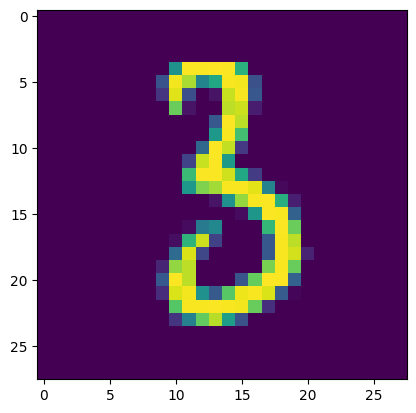

In [38]:
# Show the image
plt.imshow(X_data_reshape)

In [39]:
# Pass the image thru the model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2025][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28x28 image

In [40]:
new_prediction

tensor([[-2.2842e+01, -2.0017e+01, -1.7293e+01, -3.3897e-04, -2.8593e+01,
         -8.1419e+00, -1.3780e+01, -1.9742e+01, -9.9721e+00, -1.7057e+01]])

In [43]:
new_prediction.argmax()

tensor(3)